In [1]:
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns

sns.set_theme()

#### setup db connection

In [2]:
from sqlalchemy import create_engine


def postgresql_engine(user, pwd, host, port, dbname):
    # Need psycopg2-binary package
    sql_engine = create_engine('postgres://' + user + ':' + pwd + '@' + host + ':' + port + '/' + dbname, echo=False)
    return sql_engine

In [3]:
# DB username & password
import getpass

username = getpass.getpass()
password = getpass.getpass()

In [4]:
# misc db parameters
url = 'adds-postgres-dev.cfgztrijqgvp.us-east-1.rds.amazonaws.com'
database = 'musiclab'
port = '5432'

In [5]:
# create DB engine
engine = postgresql_engine(username, password, url, port, database)

#### read in raw features from postgres DB

In [6]:
# read raw features table
query_raw_features = '''
Select *
from adds_temp.ebw_raw_features_u1 as eh
--where extract (year from eh.song_release_date) >= 2020
'''

with engine.connect() as conn:
    with conn.begin():
        df_raw_features = pd.read_sql(query_raw_features, con=conn)

In [6]:
# write to pickle file
# df_raw_features.to_pickle('ebw_df_raw_features_h1_from_psql.pkl')

NameError: name 'df_raw_features' is not defined

In [7]:
# read in pickle file
# df_raw_features = pd.read_pickle('ebw_df_raw_features_h1_from_psql.pkl')

In [8]:
# explicit cast for date related fields
date_cols = ['week_dt', 'song_release_date', 'hit_tag_date', 'first_spin_date', 'last_spin_date', 'ftq_date',
             'last_callout_date', 'first_callout_date']

df_raw_features[date_cols] = df_raw_features[date_cols].apply(pd.to_datetime)

In [11]:
# sort data
df_raw_features.sort_values(by=['mediabase_id', 'call_letters', 'week_dt'], inplace=True)

#### calculated fields

In [9]:
# Define a dictionary of computed columns to create
computed_cols = {
    'cuml_song_station_spins_non_on': lambda df: df.groupby(['mediabase_id', 'call_letters'])['song_station_spins_non_on'].cumsum(),
    'weeks_since_first_spins': lambda df: (df['week_dt'] - df['first_spin_date']) / np.timedelta64(1, 'W'),
    'weeks_since_release': lambda df: np.round((df['week_dt'] - df['song_release_date']) / np.timedelta64(1, 'W')),
    'weeks_since_hit': lambda df: (df['week_dt'] - df['hit_tag_date']) / np.timedelta64(1, 'W'),
    'weeks_bw_ftq_first_spins': lambda df: (df['ftq_date'] - df['first_spin_date']) / np.timedelta64(1, 'W'),
    'weeks_bw_top_quintiles': lambda df: (df['hit_tag_date'] - df['ftq_date']) / np.timedelta64(1, 'W'),
    'weeks_bw_ddl_thresh_cross': lambda df: (df['ddl_over_thresh_dt_second'] - df['ddl_over_thresh_dt_first']) / np.timedelta64(1, 'W'),
    'market_spins_propn': lambda df: df['song_station_spins_non_on'] / df['song_market_spins_non_on'],
    'artist_spins_propn': lambda df: df['song_station_spins_non_on'] / df['artist_station_spins_non_on']
}

# Use assign with a dictionary comprehension to create the computed columns
df_raw_features = df_raw_features.assign(**{col_name: func(df_raw_features) for col_name, func in computed_cols.items()})

In [10]:
# Define a sub-dataframe containing only the rows where week_dt equals hit_tag_date
mask = df_raw_features['week_dt'] == df_raw_features['hit_tag_date']
sub_df = df_raw_features.loc[mask, ['mediabase_id', 'call_letters', 'week_dt', 'cuml_song_station_spins_non_on']]
sub_df = sub_df.set_index(['mediabase_id', 'call_letters'])

# Join the sub-dataframe back onto the original dataframe
df_raw_features = df_raw_features.join(sub_df, on=['mediabase_id', 'call_letters'], rsuffix='_at_hit', how='left')

In [11]:
# Define a sub-dataframe containing only the rows where week_dt equals ftq_date
mask = df_raw_features['week_dt'] == df_raw_features['ftq_date']
sub_df = df_raw_features.loc[mask, ['mediabase_id', 'call_letters', 'week_dt', 'cuml_song_station_spins_non_on']]
sub_df = sub_df.set_index(['mediabase_id', 'call_letters'])

# Join the sub-dataframe back onto the original dataframe
df_raw_features = df_raw_features.join(sub_df, on=['mediabase_id', 'call_letters'], rsuffix='_at_ftq', how='left')

In [12]:
# Filter rows where week_dt equals ddl_over_thresh_dt_first
mask = df_raw_features['week_dt'] == df_raw_features['ddl_over_thresh_dt_first']
sub_df = df_raw_features.loc[mask, ['mediabase_id', 'call_letters', 'week_dt', 'cuml_song_station_spins_non_on']]
sub_df = sub_df.set_index(['mediabase_id', 'call_letters'])

# Join sub-dataframe to original dataframe
df_raw_features = df_raw_features.join(sub_df, on=['mediabase_id', 'call_letters'], rsuffix='_at_pre_burnout',
                                       how='left')

In [13]:
# Filter rows where week_dt equals ddl_over_thresh_dt_second
mask = df_raw_features['week_dt'] == df_raw_features['ddl_over_thresh_dt_second']
sub_df = df_raw_features.loc[mask, ['mediabase_id', 'call_letters', 'week_dt', 'cuml_song_station_spins_non_on']]
sub_df = sub_df.set_index(['mediabase_id', 'call_letters'])

# Join sub-dataframe to original dataframe
df_raw_features = df_raw_features.join(sub_df, on=['mediabase_id', 'call_letters'], rsuffix='_at_burnout', how='left')

In [14]:
# measures spins to burnout after song turns into a hit
df_raw_features['spins_to_burnout_from_hit'] = df_raw_features['cuml_song_station_spins_non_on_at_burnout'] -\
                                               df_raw_features['cuml_song_station_spins_non_on_at_hit']

# measure spins to hit from ftq
df_raw_features['spins_to_hit_from_ftq'] = df_raw_features['cuml_song_station_spins_non_on_at_hit'] -\
                                           df_raw_features['cuml_song_station_spins_non_on_at_ftq']

In [15]:
df_raw_features['hit_spins_bucket'] = pd.cut(df_raw_features['cuml_song_station_spins_non_on_at_hit'], np.arange(0,
                                                                                                                 np.max(
                                                                                                                     df_raw_features[
                                                                                                                         'cuml_song_station_spins_non_on_at_hit']),
                                                                                                                 250))

In [19]:
df_raw_features['hit_spins_bucket']

0         (750.0, 1000.0]
1         (750.0, 1000.0]
2         (750.0, 1000.0]
3         (750.0, 1000.0]
4         (750.0, 1000.0]
               ...       
656334     (250.0, 500.0]
656335     (250.0, 500.0]
656336     (250.0, 500.0]
656337     (250.0, 500.0]
656338     (250.0, 500.0]
Name: hit_spins_bucket, Length: 656339, dtype: category
Categories (15, interval[float64]): [(0.0, 250.0] < (250.0, 500.0] < (500.0, 750.0] < (750.0, 1000.0] ... (2750.0, 3000.0] < (3000.0, 3250.0] < (3250.0, 3500.0] < (3500.0, 3750.0]]

In [16]:
# df_raw_features.to_pickle('ebw_raw_features_base_h1.pkl')

In [6]:
df_raw_features = pd.read_pickle('ebw_raw_features_base_h1.pkl')

#### extract unique hit information (spins/dates)

In [17]:
# de-dupe raw features to obtain unique hit info
id_cols = ['mediabase_id', 'call_letters']
date_cols = ['song_release_date', 'song_release_year', 'ftq_date', 'hit_tag_date', 'ddl_over_thresh_dt_first',
             'ddl_over_thresh_dt_second']
weeks_cols = ['weeks_bw_ftq_first_spins', 'weeks_bw_top_quintiles']
spins_cols = ['cuml_song_station_spins_non_on_at_ftq', 'cuml_song_station_spins_non_on_at_hit',
              'cuml_song_station_spins_non_on_at_pre_burnout', 'cuml_song_station_spins_non_on_at_burnout',
              'spins_to_hit_from_ftq', 'spins_to_burnout_from_hit']

# create dataframe with unique hit information
df_hits_tracker = df_raw_features[id_cols + date_cols + weeks_cols + spins_cols].drop_duplicates()

In [61]:
df_hits_tracker

,mediabase_id,call_letters,song_release_date,song_release_year,ftq_date,hit_tag_date,ddl_over_thresh_dt_first,ddl_over_thresh_dt_second,weeks_bw_ftq_first_spins,weeks_bw_top_quintiles,cuml_song_station_spins_non_on_at_ftq,cuml_song_station_spins_non_on_at_hit,cuml_song_station_spins_non_on_at_pre_burnout,cuml_song_station_spins_non_on_at_burnout,spins_to_hit_from_ftq,spins_to_burnout_from_hit
0,1086587,KHTS-FM,2022-06-01,2022.0,2022-07-10,2022-10-23,2022-11-06,2022-11-20,4.0,15.0,114.0,989.0,1086.0,1182.0,875.0,193.0
42,1086587,KIIS-FM,2022-06-01,2022.0,2022-07-03,2022-07-17,2022-08-21,None,3.0,2.0,46.0,168.0,612.0,NaN,122.0,NaN
84,1086587,KYLD-FM,2022-06-01,2022.0,2022-07-03,2022-08-14,2022-09-11,None,4.0,6.0,133.0,445.0,602.0,NaN,312.0,NaN
127,1086587,KZZP-FM,2022-06-01,2022.0,2022-07-17,2022-08-21,2022-09-18,None,5.0,5.0,187.0,592.0,748.0,NaN,405.0,NaN
169,1086587,WHTZ-FM,2022-06-01,2022.0,2022-06-19,2022-07-31,2022-09-04,2022-09-18,1.0,6.0,16.0,283.0,616.0,664.0,267.0,381.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675876,2865765,WKST-FM,2022-12-01,2022.0,2023-02-26,2023-03-12,None,None,8.0,2.0,327.0,520.0,NaN,NaN,193.0,NaN
675889,2865765,WWPW-FM,2022-12-01,2022.0,2023-02-19,2023-03-05,None,None,7.0,2.0,489.0,691.0,NaN,NaN,202.0,NaN
675902,2865765,WXKS-FM,2022-12-01,2022.0,2023-01-15,2023-02-05,None,None,2.0,3.0,51.0,240.0,NaN,NaN,189.0,NaN
675915,2865765,WXXL-FM,2022-12-01,2022.0,2023-02-19,2023-03-19,None,None,7.0,4.0,235.0,571.0,NaN,NaN,336.0,NaN


In [21]:
# determine spins cutoff for end of burn monitoring
df_hits_tracker.groupby(['song_release_year']).apply(lambda x: [len(x), np.nanquantile(x['spins_to_burnout_from_hit'], 0.05), np.nanquantile(x['spins_to_burnout_from_hit'], 0.95), (x['spins_to_burnout_from_hit'] > 2500).sum(),
                                                                (x['spins_to_burnout_from_hit'] > 2500).sum() / len(x)])

song_release_year
2017.0                         [916, 115.2, 1628.0, 0, 0.0]
2018.0    [667, 126.65, 1890.4999999999995, 2, 0.0029985...
2019.0      [650, 137.5, 2164.75, 10, 0.015384615384615385]
2020.0    [407, 106.65, 2064.4999999999977, 7, 0.0171990...
2021.0    [489, 158.5, 2489.9999999999995, 17, 0.0347648...
2022.0    [246, 176.20000000000002, 1932.1999999999994, ...
dtype: object

In [ ]:
mask = df_hits_tracker['spins_to_burnout_from_hit'] < 150
df_hits_tracker.loc[mask]

Based on the above information about 2-3% of the songs which experienced burnout in 2020 and 2021 took more than 2500 spins after turning into a hit. 2500 spins seems to be a reasonable cutoff for end of burnout monitoring

In [18]:
# define censoring flag
burn_end_spins_cutoff = 2500
df_hits_tracker['censoring_flg'] = ~(pd.isna(df_hits_tracker['ddl_over_thresh_dt_second']) | (
            df_hits_tracker['spins_to_burnout_from_hit'] > burn_end_spins_cutoff))

In [19]:
id_cols = ['mediabase_id','call_letters']
df_sub = df_raw_features.groupby(id_cols)['cuml_song_station_spins_non_on'].max().reset_index()
df_sub.columns = id_cols + ['cuml_song_station_spins_non_on_max']
df_hits_tracker = df_hits_tracker.join(df_sub.set_index(id_cols), on=id_cols)

In [43]:
df_hits_tracker.groupby(['song_release_year', 'censoring_flg'])['mediabase_id'].count()

song_release_year  censoring_flg
2017.0             False            123
                   True             793
2018.0             False            134
                   True             533
2019.0             False            134
                   True             516
2020.0             False            139
                   True             268
2021.0             False            173
                   True             316
2022.0             False            160
                   True              86
Name: mediabase_id, dtype: int64

#### feature engineering

In [16]:
rolling_weeks = [1, 4, 8 ,13, 26]
lags = [1, 2, 3, 4]

##### pop score related columns

In [22]:
pop_cols = [col for col in df_raw_features.columns if
            (('_pop' in col) or ('_ddl' in col) or ('_fav' in col)) and ('weeks_' not in col)]

In [23]:
pop_cols

['song_station_pop',
 'song_station_ddl',
 'song_station_fav',
 'count_song_format_pop',
 'song_format_pop',
 'song_format_ddl',
 'song_format_fav',
 'count_artist_format_pop',
 'artist_format_pop',
 'artist_format_ddl',
 'artist_format_fav']

##### rolling statistics look back

In [24]:
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
df_pop_features = df_raw_features[id_cols]
for win_len in rolling_weeks:
    for lag in lags:
        for col in pop_cols:
            col_name = f"{col}_{win_len}wk_lag{lag}"
            roll_col = df_raw_features.groupby(['mediabase_id', 'call_letters'])[col].rolling(window=win_len, min_periods=0)
            df_pop_features[f"{col_name}_min"] = (roll_col.min().shift(lag).droplevel([0,1])).ffill()
            df_pop_features[f"{col_name}_max"] = (roll_col.max().shift(lag).droplevel([0,1])).ffill()
            df_pop_features[f"{col_name}_mean"] = (roll_col.mean().shift(lag).droplevel([0,1])).ffill()
            df_pop_features[f"{col_name}_std"] = (roll_col.std().shift(lag).droplevel([0,1])).ffill()

In [27]:
df_pop_features.to_pickle('ebw_pop_features_h1.pkl')

In [26]:
df_pop_features[df_pop_features['weeks_since_hit'] > 0]

,mediabase_id,call_letters,week_dt,weeks_since_hit,song_station_pop_1wk_lag1_min,song_station_pop_1wk_lag1_max,song_station_pop_1wk_lag1_mean,song_station_pop_1wk_lag1_std,song_station_ddl_1wk_lag1_min,song_station_ddl_1wk_lag1_max,...,artist_format_pop_26wk_lag4_mean,artist_format_pop_26wk_lag4_std,artist_format_ddl_26wk_lag4_min,artist_format_ddl_26wk_lag4_max,artist_format_ddl_26wk_lag4_mean,artist_format_ddl_26wk_lag4_std,artist_format_fav_26wk_lag4_min,artist_format_fav_26wk_lag4_max,artist_format_fav_26wk_lag4_mean,artist_format_fav_26wk_lag4_std
20,1086587,KHTS-FM,2022-10-30,1.0,89.0,89.0,89.0,NaN,10.0,10.0,...,79.200000,5.002856,5.0,22.0,14.933333,4.636296,20.0,32.0,27.066667,2.987275
21,1086587,KHTS-FM,2022-11-06,2.0,89.0,89.0,89.0,NaN,10.0,10.0,...,79.187500,4.833477,5.0,22.0,15.125000,4.544227,20.0,32.0,27.000000,2.898275
22,1086587,KHTS-FM,2022-11-13,3.0,79.0,79.0,79.0,NaN,21.0,21.0,...,79.176471,4.680215,5.0,22.0,15.352941,4.499183,20.0,32.0,27.000000,2.806243
23,1086587,KHTS-FM,2022-11-20,4.0,79.0,79.0,79.0,NaN,21.0,21.0,...,79.333333,4.588989,5.0,22.0,15.333333,4.365641,20.0,32.0,26.944444,2.732640
24,1086587,KHTS-FM,2022-11-27,5.0,69.0,69.0,69.0,NaN,26.0,26.0,...,79.473684,4.501462,5.0,22.0,15.473684,4.286522,20.0,32.0,27.052632,2.697194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656334,2865765,WZFT-FM,2023-02-26,3.0,82.0,82.0,82.0,NaN,12.0,12.0,...,75.750000,4.349329,7.0,12.0,8.250000,2.500000,18.0,27.0,22.250000,3.774917
656335,2865765,WZFT-FM,2023-03-05,4.0,82.0,82.0,82.0,NaN,12.0,12.0,...,76.600000,4.219005,7.0,12.0,8.000000,2.236068,18.0,27.0,22.400000,3.286335
656336,2865765,WZFT-FM,2023-03-12,5.0,75.0,75.0,75.0,NaN,15.0,15.0,...,76.833333,3.816630,7.0,12.0,7.833333,2.041241,18.0,27.0,22.166667,2.994439
656337,2865765,WZFT-FM,2023-03-19,6.0,75.0,75.0,75.0,NaN,15.0,15.0,...,78.142857,4.913538,7.0,12.0,8.000000,1.914854,18.0,28.0,23.000000,3.511885


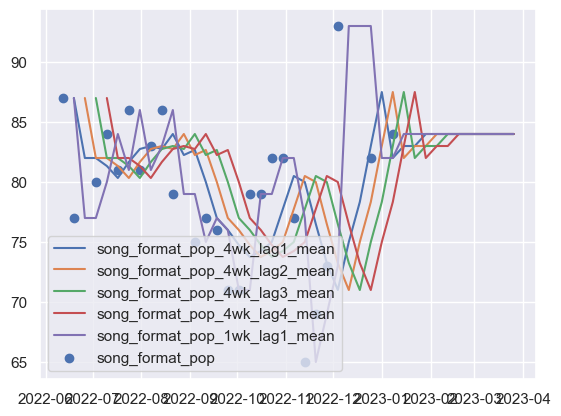

In [62]:
import matplotlib.pyplot as plt
mask = (df_raw_features['mediabase_id'] == 1086587) & (df_raw_features['call_letters'] == 'KHTS-FM')
sel_cols = ['song_format_pop','song_format_pop_4wk_lag1_mean', 'song_format_pop_4wk_lag2_mean', 'song_format_pop_4wk_lag3_mean', 'song_format_pop_4wk_lag4_mean', 'song_format_pop_1wk_lag1_mean']
plt.scatter(df_raw_features.loc[mask, 'week_dt'], df_raw_features.loc[mask, sel_cols[0]], label=sel_cols[0])
plt.plot(df_raw_features.loc[mask, 'week_dt'], df_raw_features.loc[mask, sel_cols[1]], label=sel_cols[1])
plt.plot(df_raw_features.loc[mask, 'week_dt'], df_raw_features.loc[mask, sel_cols[2]], label=sel_cols[2])
plt.plot(df_raw_features.loc[mask, 'week_dt'], df_raw_features.loc[mask, sel_cols[3]], label=sel_cols[3])
plt.plot(df_raw_features.loc[mask, 'week_dt'], df_raw_features.loc[mask, sel_cols[4]], label=sel_cols[4])
plt.plot(df_raw_features.loc[mask, 'week_dt'], df_raw_features.loc[mask, sel_cols[5]], label=sel_cols[5])
plt.legend()

##### rolling stats from ftq to hit


In [71]:
# for col in pop_cols:
#     col_name = f"{col}_ftq_to_hit"
#     col_names = [f"{col_name}_min", f"{col_name}_max", f"{col_name}_mean", f"{col_name}_std"]
#     mask = (df_raw_features['week_dt'] >= df_raw_features['week_dt_at_ftq']) & (
#             df_raw_features['week_dt'] <= df_raw_features['week_dt_at_hit'])
#     df_sub = df_raw_features.loc[mask]
#     df_sub_grpd = df_sub.groupby(['mediabase_id', 'call_letters'])[col]
#     df_temp = pd.concat([df_sub_grpd.min(), df_sub_grpd.max(), df_sub_grpd.mean(), df_sub_grpd.std()], axis=1)
#     df_temp.columns=col_names
#     df_raw_features = df_raw_features.join(df_temp, on =['mediabase_id', 'call_letters'], how='left')

##### spins related information

In [12]:
spins_cols = [col for col in df_raw_features.columns if
              ('_spins' in col) and ('cuml_' not in col) and ('_bucket' not in col) and ('_propn' not in col) and (
                      'weeks_' not in col)]

In [14]:
spins_cols

['song_station_spins_total',
 'song_station_spins_non_on',
 'song_station_spins_am_pm_dr',
 'song_format_spins_total',
 'song_format_spins_non_on',
 'song_format_spins_am_pm_dr',
 'song_market_spins_total',
 'song_market_spins_non_on',
 'song_market_spins_am_pm_dr',
 'artist_station_spins_total',
 'artist_station_spins_non_on',
 'artist_station_spins_am_pm_dr',
 'artist_format_spins_total',
 'artist_format_spins_non_on',
 'artist_format_spins_am_pm_dr',
 'artist_market_spins_total',
 'artist_market_spins_non_on',
 'artist_market_spins_am_pm_dr']

##### rolling statistics look back

In [17]:
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
df_spins_features = df_raw_features[id_cols]
for win_len in rolling_weeks:
    for lag in lags:
        for col in spins_cols:
            col_name = f"{col}_{win_len}wk_lag{lag}"
            roll_col = df_raw_features.groupby(['mediabase_id', 'call_letters'])[col].rolling(window=win_len, min_periods=0)
            df_spins_features[f"{col_name}_sum"] = (roll_col.sum().shift(lag).droplevel([0,1])).ffill()
            df_spins_features[f"{col_name}_min"] = (roll_col.min().shift(lag).droplevel([0,1])).ffill()
            df_spins_features[f"{col_name}_max"] = (roll_col.max().shift(lag).droplevel([0,1])).ffill()
            df_spins_features[f"{col_name}_mean"] = (roll_col.mean().shift(lag).droplevel([0,1])).ffill()
            df_spins_features[f"{col_name}_std"] = (roll_col.std().shift(lag).droplevel([0,1])).ffill()

In [18]:
df_spins_features.to_pickle('ebw_spins_features_h1.pkl')

In [19]:
df_spins_features.shape

(656339, 1804)

##### rolling stats from ftq to hit


In [75]:
# for col in spins_cols:
#     col_name = f"{col}_ftq_to_hit"
#     col_names = [f"{col_name}_min", f"{col_name}_max", f"{col_name}_mean", f"{col_name}_std"]
#     mask = (df_raw_features['week_dt'] >= df_raw_features['week_dt_at_ftq']) & (
#             df_raw_features['week_dt'] <= df_raw_features['week_dt_at_hit'])
#     df_sub = df_raw_features.loc[mask]
#     df_sub_grpd = df_sub.groupby(['mediabase_id', 'call_letters'])[col]
#     df_temp = pd.concat([df_sub_grpd.min(), df_sub_grpd.max(), df_sub_grpd.mean(), df_sub_grpd.std()], axis=1)
#     df_temp.columns=col_names
#     df_raw_features = df_raw_features.join(df_temp, on =['mediabase_id', 'call_letters'], how='left')

##### stream related data

In [7]:
stream_cols = [col for col in df_raw_features.columns if '_unv' in col]

In [8]:
stream_cols

['max_stream_count_prior_unv',
 'min_stream_count_prior_unv',
 'mean_stream_count_prior_unv',
 'std_stream_count_prior_unv',
 'med_stream_count_prior_unv',
 'mr_stream_count_prior_unv',
 'max_completed_count_prior_unv',
 'min_completed_count_prior_unv',
 'mean_completed_count_prior_unv',
 'std_completed_count_prior_unv',
 'med_completed_count_prior_unv',
 'mr_completed_count_prior_unv',
 'max_completed_rate_prior_unv',
 'min_completed_rate_prior_unv',
 'mean_completed_rate_prior_unv',
 'std_completed_rate_prior_unv',
 'med_completed_rate_prior_unv',
 'mr_completed_rate_prior_unv',
 'max_thumbs_up_rate_prior_unv',
 'min_thumbs_up_rate_prior_unv',
 'mean_thumbs_up_rate_prior_unv',
 'std_thumbs_up_rate_prior_unv',
 'med_thumbs_up_rate_prior_unv',
 'mr_thumbs_up_rate_prior_unv']

In [9]:
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
df_streams_features = df_raw_features[id_cols + stream_cols]

In [10]:
df_streams_features

,mediabase_id,call_letters,week_dt,weeks_since_hit,max_stream_count_prior_unv,min_stream_count_prior_unv,mean_stream_count_prior_unv,std_stream_count_prior_unv,med_stream_count_prior_unv,mr_stream_count_prior_unv,...,mean_completed_rate_prior_unv,std_completed_rate_prior_unv,med_completed_rate_prior_unv,mr_completed_rate_prior_unv,max_thumbs_up_rate_prior_unv,min_thumbs_up_rate_prior_unv,mean_thumbs_up_rate_prior_unv,std_thumbs_up_rate_prior_unv,med_thumbs_up_rate_prior_unv,mr_thumbs_up_rate_prior_unv
0,1086587,KHTS-FM,2022-06-12,-19.0,11852.0,9952.0,11377.000000,859.307332,11852.0,11852.0,...,0.688990,0.004898,0.691698,0.691698,0.979094,0.938017,0.948286,0.018578,0.938017,0.938017
1,1086587,KHTS-FM,2022-06-19,-18.0,12578.0,9952.0,11922.909091,872.602616,11852.0,12578.0,...,0.688697,0.003560,0.688345,0.688345,0.979094,0.938017,0.953009,0.014451,0.958678,0.958678
2,1086587,KHTS-FM,2022-06-26,-17.0,12578.0,9952.0,11920.125000,718.212106,11914.0,11914.0,...,0.686726,0.004172,0.688345,0.682390,0.979094,0.938017,0.955675,0.012554,0.958678,0.961538
3,1086587,KHTS-FM,2022-07-03,-16.0,22934.0,9952.0,14542.476190,4788.763857,11914.0,22934.0,...,0.670828,0.029012,0.682390,0.619953,0.979094,0.938017,0.952516,0.012324,0.958678,0.942408
4,1086587,KHTS-FM,2022-07-10,-15.0,22934.0,9952.0,15050.461538,4420.497170,12578.0,17184.0,...,0.667968,0.026677,0.682390,0.655959,0.979094,0.938017,0.954275,0.011633,0.958678,0.961661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656334,2865765,WZFT-FM,2023-02-26,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
656335,2865765,WZFT-FM,2023-03-05,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
656336,2865765,WZFT-FM,2023-03-12,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
656337,2865765,WZFT-FM,2023-03-19,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_streams_features.to_pickle('ebw_streams_features_h1.pkl')

##### rolling statistics look back

In [ ]:
# for win_len in rolling_weeks:
#     for lag in lags:
#         for col in stream_cols:
#             col_name = f"{col}_prior_{win_len}wk_lag{lag}"
#             roll_col = df_raw_features.groupby(['mediabase_id', 'call_letters'])[col].rolling(window=win_len, min_periods=0)
#             df_raw_features[f"{col_name}_min"] = (roll_col.min().shift(lag).droplevel([0,1])).ffill()
#             df_raw_features[f"{col_name}_max"] = (roll_col.max().shift(lag).droplevel([0,1])).ffill()
#             df_raw_features[f"{col_name}_mean"] = (roll_col.mean().shift(lag).droplevel([0,1])).ffill()
#             # df_raw_features[f"{col_name}_std"] = (roll_col.std().shift(1).droplevel([0,1])).ffill()

##### rolling stats from ftq to hit


In [79]:
# for col in stream_cols:
#     col_name = f"{col}_ftq_to_hit"
#     col_names = [f"{col_name}_min", f"{col_name}_max", f"{col_name}_mean", f"{col_name}_std"]
#     mask = (df_raw_features['week_dt'] >= df_raw_features['week_dt_at_ftq']) & (
#             df_raw_features['week_dt'] <= df_raw_features['week_dt_at_hit'])
#     df_sub = df_raw_features.loc[mask]
#     df_sub_grpd = df_sub.groupby(['mediabase_id', 'call_letters'])[col]
#     df_temp = pd.concat([df_sub_grpd.min(), df_sub_grpd.max(), df_sub_grpd.mean(), df_sub_grpd.std()], axis=1)
#     df_temp.columns=col_names
#     df_raw_features = df_raw_features.join(df_temp, on =['mediabase_id', 'call_letters'], how='left')

##### proportion related data

In [23]:

[ col for col in df_spins_features.columns if ('_sum' in col) and (('song_station_spins_non_on' in col) or ('song_market_spins_non_on' in col))]

['song_station_spins_non_on_1wk_lag1_sum',
 'song_market_spins_non_on_1wk_lag1_sum',
 'song_station_spins_non_on_1wk_lag2_sum',
 'song_market_spins_non_on_1wk_lag2_sum',
 'song_station_spins_non_on_1wk_lag3_sum',
 'song_market_spins_non_on_1wk_lag3_sum',
 'song_station_spins_non_on_1wk_lag4_sum',
 'song_market_spins_non_on_1wk_lag4_sum',
 'song_station_spins_non_on_4wk_lag1_sum',
 'song_market_spins_non_on_4wk_lag1_sum',
 'song_station_spins_non_on_4wk_lag2_sum',
 'song_market_spins_non_on_4wk_lag2_sum',
 'song_station_spins_non_on_4wk_lag3_sum',
 'song_market_spins_non_on_4wk_lag3_sum',
 'song_station_spins_non_on_4wk_lag4_sum',
 'song_market_spins_non_on_4wk_lag4_sum',
 'song_station_spins_non_on_8wk_lag1_sum',
 'song_market_spins_non_on_8wk_lag1_sum',
 'song_station_spins_non_on_8wk_lag2_sum',
 'song_market_spins_non_on_8wk_lag2_sum',
 'song_station_spins_non_on_8wk_lag3_sum',
 'song_market_spins_non_on_8wk_lag3_sum',
 'song_station_spins_non_on_8wk_lag4_sum',
 'song_market_spins_no

In [80]:
propn_cols = [col for col in df_raw_features.columns if 'propn' in col]

In [81]:
propn_cols

['market_spins_propn', 'artist_spins_propn']

In [28]:
df_spins_features.shape

(656339, 1804)

In [31]:
df_test = df_spins_features.set_index(['call_letters', 'mediabase_id', 'week_dt'])['song_station_spins_non_on_1wk_lag1_sum']/df_spins_features.groupby(['call_letters', 'week_dt'])['song_station_spins_non_on_1wk_lag1_sum'].sum()

In [36]:
df_spins_features

,mediabase_id,call_letters,week_dt,weeks_since_hit,song_station_spins_total_1wk_lag1_sum,song_station_spins_total_1wk_lag1_min,song_station_spins_total_1wk_lag1_max,song_station_spins_total_1wk_lag1_mean,song_station_spins_total_1wk_lag1_std,song_station_spins_non_on_1wk_lag1_sum,...,artist_market_spins_non_on_26wk_lag4_sum,artist_market_spins_non_on_26wk_lag4_min,artist_market_spins_non_on_26wk_lag4_max,artist_market_spins_non_on_26wk_lag4_mean,artist_market_spins_non_on_26wk_lag4_std,artist_market_spins_am_pm_dr_26wk_lag4_sum,artist_market_spins_am_pm_dr_26wk_lag4_min,artist_market_spins_am_pm_dr_26wk_lag4_max,artist_market_spins_am_pm_dr_26wk_lag4_mean,artist_market_spins_am_pm_dr_26wk_lag4_std
0,1086587,KHTS-FM,2022-06-12,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1086587,KHTS-FM,2022-06-19,-18.0,17.0,17.0,17.0,17.0,NaN,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1086587,KHTS-FM,2022-06-26,-17.0,30.0,30.0,30.0,30.0,NaN,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1086587,KHTS-FM,2022-07-03,-16.0,29.0,29.0,29.0,29.0,NaN,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1086587,KHTS-FM,2022-07-10,-15.0,37.0,37.0,37.0,37.0,NaN,31.0,...,45.0,45.0,45.0,45.000000,NaN,22.0,22.0,22.0,22.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656334,2865765,WZFT-FM,2023-02-26,3.0,108.0,108.0,108.0,108.0,NaN,80.0,...,447.0,31.0,139.0,89.400000,46.182248,312.0,22.0,91.0,62.400000,31.572140
656335,2865765,WZFT-FM,2023-03-05,4.0,121.0,121.0,121.0,121.0,NaN,91.0,...,606.0,31.0,159.0,101.000000,50.135816,416.0,22.0,104.0,69.333333,32.952491
656336,2865765,WZFT-FM,2023-03-12,5.0,129.0,129.0,129.0,129.0,NaN,97.0,...,767.0,31.0,161.0,109.571429,51.077905,522.0,22.0,106.0,74.571429,33.120271
656337,2865765,WZFT-FM,2023-03-19,6.0,121.0,121.0,121.0,121.0,NaN,91.0,...,948.0,31.0,181.0,118.500000,53.609701,650.0,22.0,128.0,81.250000,36.014878


In [ ]:
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
df_spins_propn_features = df_raw_features[id_cols]
for win_len in rolling_weeks:
    for lag in lags:
        df_spins_propn_features[f'song_station_spins_non_on_{wk}_lag{lag}_sum'] = f'song_station_spins_non_on_{wk}_lag{lag}_sum'
        col_name_artist = f''

##### rolling statistics look back

In [82]:
# for win_len in rolling_weeks:
#     for col in propn_cols:
#         col_name = f"{col}_prior_{win_len}wk"
#         roll_col = df_raw_features.groupby(['mediabase_id', 'call_letters'])[col].rolling(window=win_len, min_periods=0)
#         df_raw_features[f"{col_name}_min"] = (roll_col.min().shift(1).droplevel([0,1])).ffill()
#         df_raw_features[f"{col_name}_max"] = (roll_col.max().shift(1).droplevel([0,1])).ffill()
#         df_raw_features[f"{col_name}_mean"] = (roll_col.mean().shift(1).droplevel([0,1])).ffill()
#         df_raw_features[f"{col_name}_std"] = (roll_col.std().shift(1).droplevel([0,1])).ffill()

In [ ]:
'market_spins_propn': lambda df: df['song_station_spins_non_on'] / df['song_market_spins_non_on'],
'artist_spins_propn': lambda df: df['song_station_spins_non_on'] / df['artist_station_spins_non_on']

##### rolling stats from ftq to hit


In [83]:
# for col in propn_cols:
#     col_name = f"{col}_ftq_to_hit"
#     col_names = [f"{col_name}_min", f"{col_name}_max", f"{col_name}_mean", f"{col_name}_std"]
#     mask = (df_raw_features['week_dt'] >= df_raw_features['week_dt_at_ftq']) & (
#             df_raw_features['week_dt'] <= df_raw_features['week_dt_at_hit'])
#     df_sub = df_raw_features.loc[mask]
#     df_sub_grpd = df_sub.groupby(['mediabase_id', 'call_letters'])[col]
#     df_temp = pd.concat([df_sub_grpd.min(), df_sub_grpd.max(), df_sub_grpd.mean(), df_sub_grpd.std()], axis=1)
#     df_temp.columns=col_names
#     df_raw_features = df_raw_features.join(df_temp, on =['mediabase_id', 'call_letters'], how='left')

In [70]:
df_raw_features.shape

(675941, 3644)

In [ ]:
# propogate censoring flag back to raw features
join_cols = ['mediabase_id', 'call_letters']
df_sub = df_hits_tracker.set_index(join_cols)['censoring_flg']

df_raw_features = df_raw_features.join(df_sub, on=join_cols, how='left')

In [71]:
df_hits_tracker.to_pickle('ebw_hits_tracker_h1.pkl')
df_raw_features.to_pickle('ebw_temp_features_h1.pkl')

In [ ]:
# import pandas as pd
# df_raw_features = pd.read_pickle('ebw_temp_features_h1.pkl')
# df_hits_tracker = pd.read_pickle('ebw_hits_tracker_h1.pkl')

<AxesSubplot:>

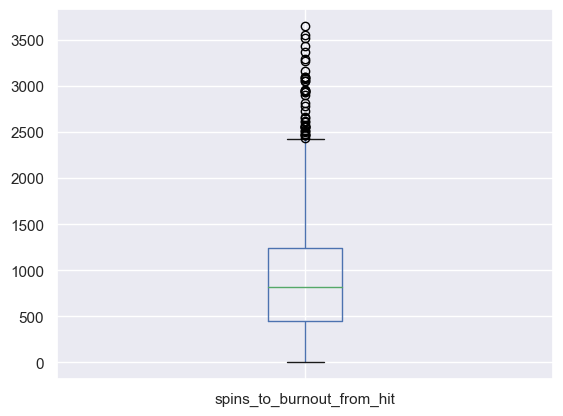

In [93]:
df_hits_tracker['spins_to_burnout_from_hit'].plot(kind='box')

<AxesSubplot:ylabel='Frequency'>

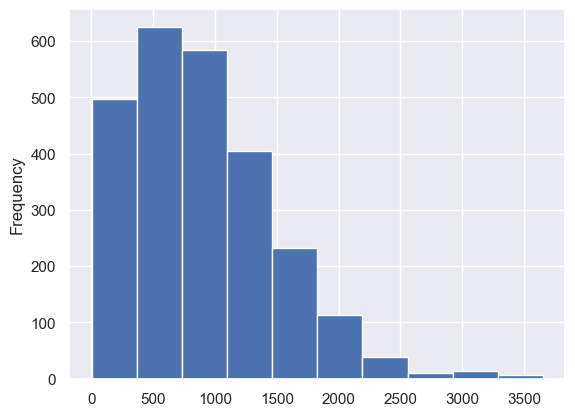

In [92]:
df_hits_tracker['spins_to_burnout_from_hit'].plot(kind='hist')

#### create percentage delta features

In [6]:
df_temp_features = pd.read_pickle('ebw_temp_features_h1.pkl')

In [8]:
df_temp_features.sort_values(by=['mediabase_id', 'call_letters', 'week_dt'], inplace=True)

In [9]:
change_cols = list(set([col for col in df_temp_features.columns if 'wk' in col]) - set([col for col in df_temp_features.columns if '1wk' in col]) - set([col for col in df_temp_features.columns if 'std' in col]))

In [10]:
change_cols

['max_stream_count_prior_unv_prior_26wk_mean',
 'med_completed_count_prior_unv_prior_4wk_mean',
 'count_song_format_pop_prior_8wk_max',
 'mr_stream_count_prior_unv_prior_4wk_max',
 'song_station_spins_total_prior_13wk_mean',
 'artist_format_spins_am_pm_dr_prior_4wk_mean',
 'artist_format_spins_non_on_prior_4wk_mean',
 'artist_market_spins_am_pm_dr_prior_26wk_min',
 'market_spins_propn_prior_26wk_mean',
 'artist_station_spins_non_on_prior_8wk_mean',
 'song_format_ddl_prior_13wk_max',
 'song_station_fav_prior_8wk_max',
 'mean_completed_rate_prior_unv_prior_4wk_max',
 'artist_market_spins_non_on_prior_13wk_max',
 'song_market_spins_total_prior_13wk_min',
 'artist_format_ddl_prior_8wk_mean',
 'count_song_format_pop_prior_4wk_mean',
 'artist_market_spins_non_on_prior_8wk_min',
 'mean_completed_count_prior_unv_prior_4wk_min',
 'med_completed_count_prior_unv_prior_8wk_min',
 'artist_station_spins_non_on_prior_4wk_mean',
 'min_completed_rate_prior_unv_prior_13wk_max',
 'song_format_fav_prior_4

In [11]:
df_temp_features = df_temp_features.assign(**{col + '_pct_chg': df_temp_features.groupby(['mediabase_id', 'call_letters'])[col].pct_change().replace([np.inf], 1.0).replace([-np.inf], -1.0).fillna(0) for col in change_cols})

In [98]:
df_temp_features.columns

Index(['mediabase_id', 'song_id', 'call_letters', 'market_name', 'artist_id',
       'format_code', 'song_release_date', 'first_callout_date',
       'last_callout_date', 'first_spin_date',
       ...
       'artist_station_spins_total_prior_4wk_min_pct_chg',
       'artist_market_spins_total_prior_8wk_max_pct_chg',
       'song_station_pop_prior_4wk_max_pct_chg',
       'artist_format_fav_prior_26wk_mean_pct_chg',
       'min_stream_count_prior_unv_prior_4wk_max_pct_chg',
       'med_thumbs_up_rate_prior_unv_prior_4wk_min_pct_chg',
       'med_completed_count_prior_unv_prior_4wk_min_pct_chg',
       'artist_format_pop_prior_13wk_min_pct_chg',
       'mr_thumbs_up_rate_prior_unv_prior_8wk_max_pct_chg',
       'count_artist_format_pop_prior_4wk_min_pct_chg'],
      dtype='object', length=2025)

song_station_ddl_prior_13wk_max_pct_chg


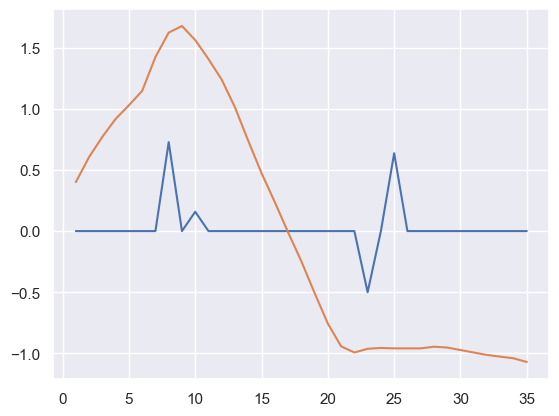

In [36]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
med_id = df_temp_features.loc[400]['mediabase_id']
call_letters = df_temp_features.loc[400]['call_letters']
mask = (df_temp_features['mediabase_id'] == med_id) & (df_temp_features['call_letters'] == call_letters) & (df_temp_features['weeks_since_hit'] > 0)
df_sub = df_temp_features.loc[mask]
scaler = StandardScaler()

for wk in [13]:
    col_name = f'song_station_ddl_prior_{wk}wk_max_pct_chg'
    col_name_spins = f'song_station_spins_non_on_prior_{wk}wk_mean'
    scaler.fit(df_sub[[col_name_spins]])
    df_sub[col_name_spins] = scaler.transform(df_sub[[col_name_spins]])
    print(col_name)
    plt.plot(df_sub['weeks_since_hit'], df_sub[col_name])
    plt.plot(df_sub['weeks_since_hit'], df_sub[col_name_spins])

In [37]:
df_temp_features.to_pickle('ebw_temp_features_with_chg_h1.pkl')